In [66]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font='CMU Serif',
        rc={'font.size':12, 'mathtext.fontset': 'cm', "grid.linewidth": 0.5, "axes.grid": True, "axes.grid.axis": "x"})

In [2]:
class Inputs():
    def __init__(self, deltaP, maxSamples, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [51]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0,
        w_time=0, w_ramp=0.2, w_delta=0, T=0.3, S=[0,0]):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_evidence = lambda t: inputs.get_AB(t)
    func_thr = lambda t: T
    func_start = lambda t: S if t<1 else [0,0]
    func_urgency = lambda t: -w_time * t
    func_ramp = lambda x: tau * w_ramp * x
    func_uncertainty = lambda x: -w_delta * np.abs(x[0]-x[1])
    func_greater = lambda x: [x[0]-x[1], x[1]-x[0]] 
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)
    dInh = -1e1*np.ones((2*nNeurons, 1))

    with net:
        # Inputs
        evidence = nengo.Node(func_evidence)
        time = nengo.Node(func_urgency)
        thr = nengo.Node(func_thr)
        start = nengo.Node(func_start)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        combined = nengo.Ensemble(2*nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        
        # Connections
        nengo.Connection(evidence, value.input)
        nengo.Connection(start[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(start[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, combined)
        nengo.Connection(combined, gate, function=func_uncertainty)
        nengo.Connection(combined, action.input, function=func_greater)
        nengo.Connection(time, gate)
        nengo.Connection(thr, gate)
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])

        # Probes
        net.pEvidence = nengo.Probe(evidence)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.w_ramp = w_ramp
        net.w_delta = w_delta
        
    return net

In [52]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.0):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = True
            time = timeA
        elif timeB < timeA:
            correct = False
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = True
            time = timeB
        elif timeA < timeB:
            correct = False
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [79]:
def run_once(deltaP, maxSamples, seed, dt=0.001, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    net = build_network(inputs, seed=seed, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    with sim:
        sim.run(maxSamples, progress_bar=True)

    idealA = np.cumsum(sim.data[net.pEvidence][:,0]) * net.w_ramp * dt
    idealB = np.cumsum(sim.data[net.pEvidence][:,1]) * net.w_ramp * dt
    ymin = np.around(np.min(np.concatenate((idealA, idealB))), 1)
    ymax = np.around(np.max(np.concatenate((idealA, idealB))), 1)
    y2a = np.around(np.max(np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1])), 1)
    y2b = np.around(np.max(sim.data[net.pGate]), 1)
    correct, cues, time = is_correct(inputs, net, sim)
    title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f} (dP={deltaP})"

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((6.38, 4)))
    axes[0].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
    axes[0].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
    axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
    axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0], zorder=0)
    axes[1].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1], zorder=0)
    axes[1].plot(sim.trange(), sim.data[net.pGate], label='gate', color=palette[2])
    axes[1].plot(sim.trange(), np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1]), label='delta', color=palette[4])
    axes[1].scatter(time, 0, s=50, color='g' if correct else 'r', zorder=1)
    axes[0].set(ylabel="Accumulated Evidence", title=title, yticks=((ymin, ymax)))
    axes[1].set(ylabel="Decision Criteria", yticks=((0, y2a, y2b)), xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

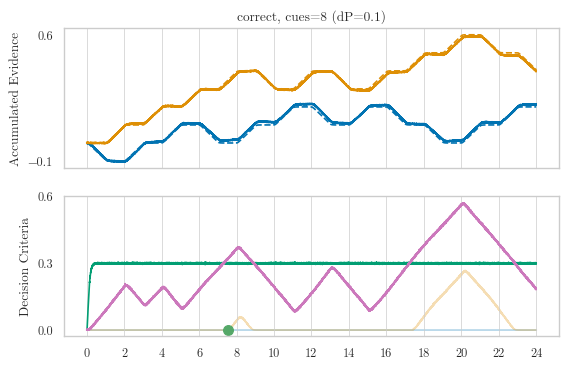

In [80]:
run_once(deltaP=0.1, maxSamples=12, seed=0, T=0.3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

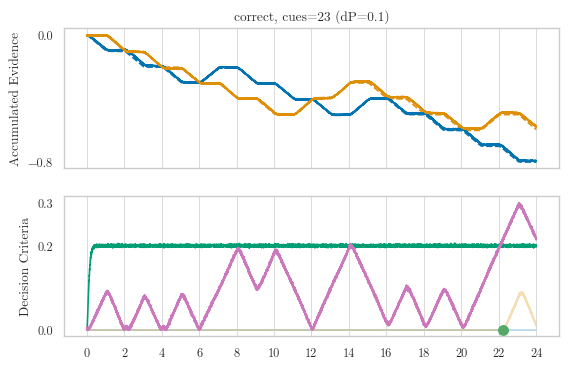

In [81]:
run_once(deltaP=0.1, maxSamples=12, seed=8, T=0.2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

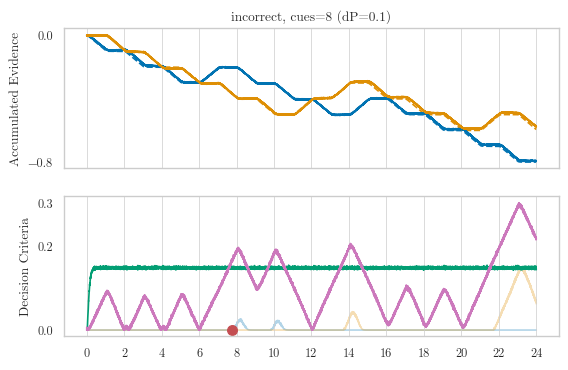

In [82]:
run_once(deltaP=0.1, maxSamples=12, seed=8, T=0.15)

In [83]:
def run_param_comparison(param, params, deltaP, maxSamples=12, seed=0,
        dt=0.001, plot_time=True, **kwargs):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=((6.38, 4)))
    for i, p in enumerate(params):
        print(f"{param} = {p}")
        if param=="T":
            net = build_network(inputs, seed=seed, T=p, **kwargs)
            title = "decision threshold"
            ylabel = r"$T="+str(p)+"$"
        if param=="S":
            net = build_network(inputs, seed=seed, S=p, **kwargs)
            title = "starting evidence"
            ylabel = r"$S="+str(p)+"$"
        if param=="w_ramp":
            net = build_network(inputs, seed=seed, w_ramp=p, **kwargs)
            title = "ramp rate"
            ylabel = r"$w_{ramp}="+str(p)+"$"
        if param=="w_time":
            net = build_network(inputs, seed=seed, w_time=p, **kwargs)
            title = "temporal urgency"
            ylabel = r"$w_{time}="+str(p)+"$"
        if param=="w_delta":
            net = build_network(inputs, seed=seed, w_delta=p, **kwargs)
            title = "confidence"
            ylabel = r"$w_{delta}="+str(p)+"$"
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)

        idealA = np.cumsum(sim.data[net.pEvidence][:,0]) * net.w_ramp * dt
        idealB = np.cumsum(sim.data[net.pEvidence][:,1]) * net.w_ramp * dt
        ymin = np.around(np.min(np.concatenate((idealA, idealB))), 1)
        ymax = np.around(np.max(np.concatenate((idealA, idealB))), 1)
        y2a = np.around(np.max(np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1])), 1)
        y2b = np.around(np.max(sim.data[net.pGate]), 1)
        correct, cues, time = is_correct(inputs, net, sim)
        axes[i][0].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
        axes[i][0].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
        axes[i][0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
        axes[i][0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
        axes[i][1].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0], zorder=0)
        axes[i][1].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1], zorder=0)
        axes[i][1].plot(sim.trange(), sim.data[net.pGate], label='gate', color=palette[2])
        axes[i][1].plot(sim.trange(), np.abs(sim.data[net.pAccumulate][:,0]-sim.data[net.pAccumulate][:,1]), label='delta', color=palette[4])
        axes[i][1].scatter(time, 0, s=50, color='g' if correct else 'r', zorder=1)
        axes[i][0].set(ylabel=ylabel, yticks=((ymin, ymax)))
        axes[i][1].set(yticks=((0, y2a, y2b)))
        axes[2][0].set(xlabel="cues", xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
        axes[2][1].set(xlabel="cues", xticks=np.arange(0, maxSamples+1, 1), xticklabels=np.arange(0, 2*maxSamples+2, 2))
        plt.tight_layout()
        fig.savefig(f"dynamics_{param}.svg")
        fig.savefig(f"dynamics_{param}.png", dpi=600)

T = 0.3
T = 0.2
T = 0.1


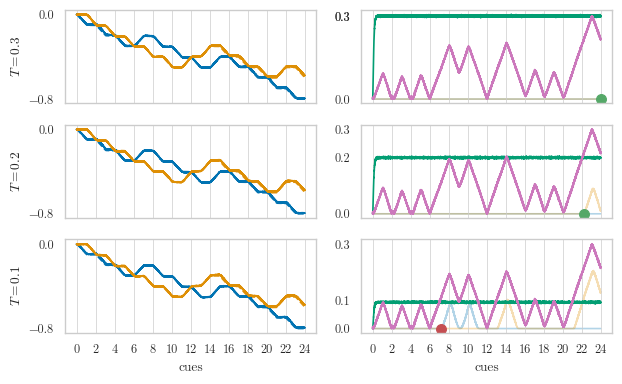

In [84]:
run_param_comparison("T", [0.3, 0.2, 0.1], deltaP=0.1, seed=8)

w_time = 0.0
w_time = 0.02
w_time = 0.04


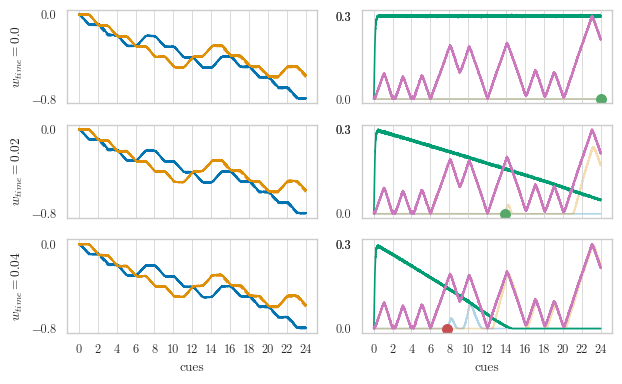

In [90]:
run_param_comparison("w_time", [0.0, 0.02, 0.04], deltaP=0.1, seed=8)

w_ramp = 0.1
w_ramp = 0.2
w_ramp = 0.3


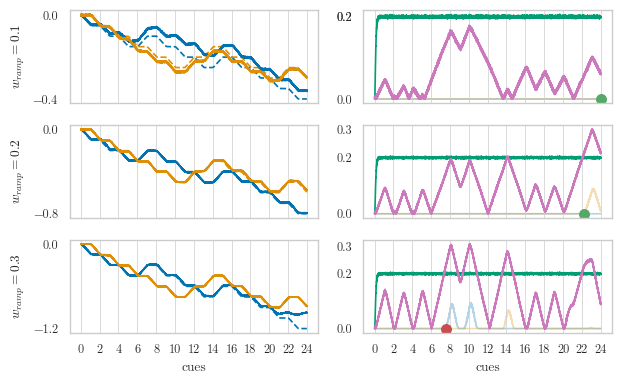

In [92]:
run_param_comparison("w_ramp", [0.1, 0.2, 0.3], T=0.2, deltaP=0.1, seed=8)

w_delta = 0.0
w_delta = 0.5
w_delta = 1.0


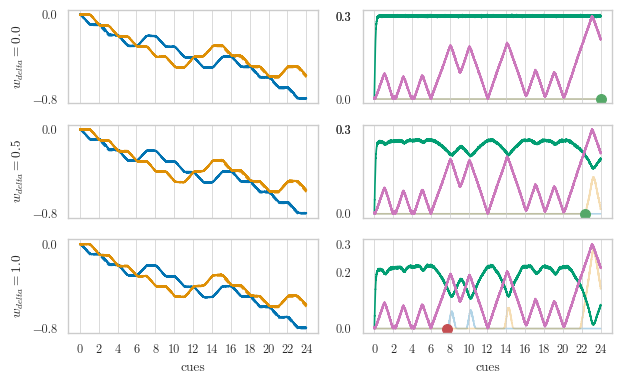

In [95]:
run_param_comparison("w_delta", [0.0, 0.5, 1.0], deltaP=0.1, seed=8)

In [96]:
def scan_parameter(scan, nNetworks, nTrials, deltaPs,
                   maxSamples=12, dt=0.001, low=0.1, high=0.3, load=False, **kwargs):
    if load:
        data = pd.read_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        collapsed_data = pd.read_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    else:
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'trial', 'correct', 'cues')
        rng = np.random.RandomState(seed=nNetworks)
        params = np.linspace(low, high, nNetworks)
        for s in range(nNetworks):
            print(f"seed {s}")
            param = params[s]
            for dP in deltaPs:
                print(f"dP {dP}")
                inputs = Inputs(deltaP=dP, maxSamples=maxSamples, seed=s)
                for n in range(nTrials):
                    print(f"trial {n}")
                    inputs.set_AB()
                    if scan=="T":
                        net = build_network(inputs, seed=s, T=param, **kwargs)
                    elif scan=="w_ramp":
                        net = build_network(inputs, seed=s, w_ramp=param, **kwargs)
                    elif scan=="w_time":
                        net = build_network(inputs, seed=s, w_time=param, **kwargs)
                    elif scan=="w_delta":
                        net = build_network(inputs, seed=s, w_delta=param, **kwargs)
                    else:
                        raise
                    sim = nengo.Simulator(net, progress_bar=False)
                    with sim:
                        sim.run(maxSamples, progress_bar=False)
                    correct, cues, time = is_correct(inputs, net, sim)
                    dfs.append(pd.DataFrame([[scan, param, s, dP, n, correct, cues]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}.pkl")
        print(data)
        # collapse data by individual  (take mean of cues and accuracy)
        dfs = []
        columns = ('scan', 'param', 'seed', 'dP', 'mean correct', 'mean cues')
        for s in range(data['seed'].max()+1):
            for dP in data['dP'].unique():
                d = data.query("seed==@s and dP==@dP")
                dfs.append(pd.DataFrame([[
                    scan, d['param'].mean(), s, np.around(d['dP'].mean(),2), d['correct'].mean(), d['cues'].mean()
                    ]], columns=columns))
        collapsed_data = pd.concat(dfs, ignore_index=True)
        collapsed_data.to_pickle(f"scan_{scan}_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
    return(collapsed_data)

In [104]:
sns.set(context='paper', style='white', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [112]:
data = scan_parameter(scan="T", nNetworks=10, nTrials=10, deltaPs=[0.4, 0.2, 0.1], low=0.2, high=0.4, load=False)

seed 0
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 1
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 2
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 3
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 4
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 5
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
trial 0
trial 1
trial 2
trial 3
trial 4
seed 6
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.2
trial 0
trial 1
trial 2
trial 3
trial 4
dP 0.1
tria

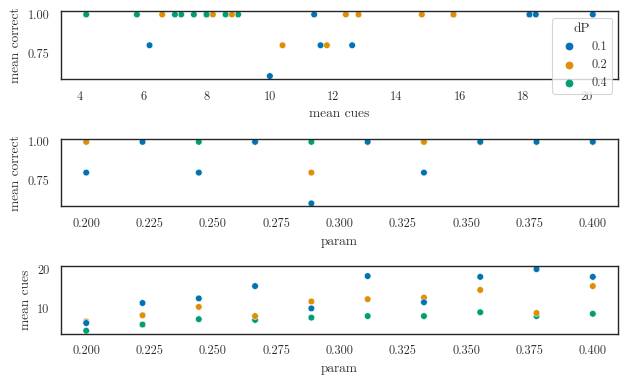

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=axes[0], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean correct", hue='dP', ax=axes[1], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean cues", hue='dP', ax=axes[2], palette=palette[:3])
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
data = scan_parameter(scan="w_time", nNetworks=10, nTrials=10, deltaPs=[0.4, 0.2, 0.1], low=0.0, high=0.05, load=False)

seed 0
dP 0.4
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=axes[0], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean correct", hue='dP', ax=axes[1], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean cues", hue='dP', ax=axes[2], palette=palette[:3])
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
data = scan_parameter(scan="w_ramp", nNetworks=10, nTrials=10, deltaPs=[0.4, 0.2, 0.1], low=0.1, high=0.3, load=False)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=axes[0], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean correct", hue='dP', ax=axes[1], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean cues", hue='dP', ax=axes[2], palette=palette[:3])
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
data = scan_parameter(scan="w_delta", nNetworks=10, nTrials=10, deltaPs=[0.4, 0.2, 0.1], low=0.0, high=1.0, load=False)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)))
sns.scatterplot(data=data, x="mean cues", y="mean correct", hue='dP', ax=axes[0], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean correct", hue='dP', ax=axes[1], palette=palette[:3])
sns.scatterplot(data=data, x="param", y="mean cues", hue='dP', ax=axes[2], palette=palette[:3])
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
plt.show()

# Empirical Data

In [115]:
def format_empirical_data():
    data = pd.read_excel("empirical.xlsx", header=0)
    # remove test data, then remove redundant "tag" field
    for i, tag in enumerate(data['tag'].unique()):
        if type(tag)=='float':
            continue  # data wasn't label with tester tag
#         if type(tag)=='float' and np.isnan(tag):
#             data = data.drop(data[data.tag==tag].index)  # suspicious lack of tag
        if tag in ["Testversion", "TEST JOHANNES / LOL", "999", "Johannes Test 2"]:
            data = data.drop(data[data.tag==tag].index)
    data = data.drop(columns=['tag'])
    # rename sample_size to maxSamples
    data = data.rename(columns={'sample_size': 'maxSamples'})
    # rename ticks to cues
    data = data.rename(columns={'ticks': 'cues'})
    # add a "correct" column based on "selected right" and comparing "p1" to "p2"
    chosen_answer = data['selected_right'].to_numpy()
    correct_answer = data['p2'].to_numpy() > data['p1'].to_numpy()
    correct = chosen_answer == correct_answer
#     print(chosen_answer)
#     print(correct_answer)
#     print(correct, len(correct))
    data['correct'] = correct
    # add a column for the number of cues, for the selected option only, visible at the time of choice
    arg_right = np.where(chosen_answer==1)[0]
    arg_left = np.where(chosen_answer==0)[0]
    cues_chosen = chosen_answer  # 1 for right, 0 for left
    cues_chosen[arg_right] = data['last_right'].to_numpy()[arg_right]
    cues_chosen[arg_left] = data['last_left'].to_numpy()[arg_left]
    data['cues for chosen option'] = cues_chosen
    # remove remaining columns
    data = data.drop(columns=[
        'timestamp', 'subrange_key', 'duration_ms', 'empirical_delta', 'empirical_p1', 'empirical_p2',
        'selected_right', 'started_right', 'last_left', 'last_right', 'left', 'right'
    ])
    # first participant is fake
    data = data.drop(data[data.participant_id=="11e92cd2764348faa18918c94947d4fa"].index)
    data.to_pickle("empirical_data.pkl")

In [116]:
def collapse_empirical_data():
    data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12")
    dfs = []
    columns = ('ID', 'dP', 'mean correct', 'mean cues', 'mean cues for chosen option', 'trials')
    for s in data['participant_id'].unique():
        for dP in data['delta'].unique():
            d = data.query("participant_id==@s and delta==@dP")
            dfs.append(pd.DataFrame([[
                s, dP, d['correct'].mean(), d['cues'].mean(), d['cues for chosen option'].mean(), d['correct'].size,
                ]], columns=columns))
    collapsed_data = pd.concat(dfs, ignore_index=True)
    collapsed_data.to_pickle("collapsed_empirical_data.pkl")
    collapsed_data

In [117]:
format_empirical_data()
collapse_empirical_data()

In [120]:
collapsed_empirical_data = pd.read_pickle("collapsed_empirical_data.pkl")

<AxesSubplot: xlabel='trials', ylabel='Count'>

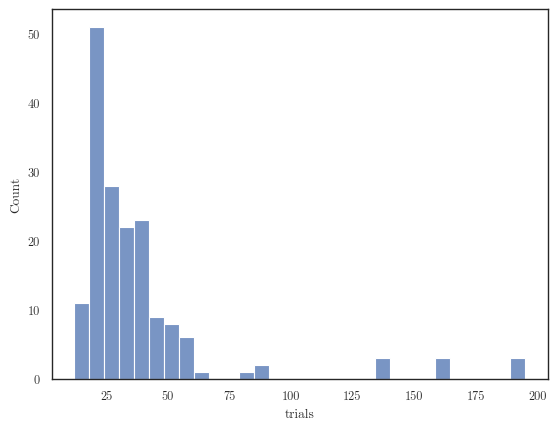

In [121]:
sns.histplot(collapsed_empirical_data['trials'])